In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer,SimpleImputer
from sklearn.model_selection import train_test_split, KFold,cross_val_score,StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error,accuracy_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.losses import binary_crossentropy
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
np.random.seed(42)
import xgboost as xgb
import tensorflow as tf
from lightgbm import LGBMClassifier
import tensorflow.keras.backend as K
import tensorflow as tf
import seaborn as sns

In [108]:
path = "/kaggle/input/icr-identify-age-related-conditions/"
df=pd.read_csv(path+"train.csv")
df

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,...,0.173229,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,0
613,fd895603f071,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,...,10.223150,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340,0
614,fd8ef6377f76,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,...,0.173229,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000,0
615,fe1942975e40,0.363205,1263.53524,85.200147,23.685856,8.138688,7.981959,0.025578,7.524588,1.229900,...,9.256996,0.78764,0.670527,24.594488,72.611063,1965.343176,25.116750,37.155112,0.184622,0


In [111]:
df["EJ"]=df["EJ"].map({"A":1,"B":0})
df.drop("Id",axis=1,inplace=True)
non_categorical_col = [col for col in df.columns if col not in ["EJ","Class"]]

In [28]:
class Model():
    def __init__(self,model1,model2,model3):
        self.model1=model1
        self.model2=model2
        self.model3=model3
        
    def fit(self,x,y):
        self.model1.fit(x,y)
        self.model2.fit(x,y)
        self.model3.fit(x,y)
        
    def predict(self,x):
        pred1 = self.model1.predict_proba(x)
        pred2 = self.model2.predict_proba(x)
        pred3 = self.model3.predict_proba(x)
        res=[]
        for i in range(len(pred1)):
            preds = [abs(pred1[i][0]-pred1[i][1]),abs(pred2[i][0]-pred2[i][1]),abs(pred2[i][0]-pred2[i][1])]
            z=max(preds)
            idx = preds.index(z)
            if idx == 0:
                res.append(1 if pred1[i][0] < 0.5 else 0)
            elif idx == 1:
                res.append(1 if pred2[i][0] < 0.5 else 0)
            else:
                res.append(1 if pred3[i][0] < 0.5 else 0)
        return res
            
    def predict_proba(self,x):
        pred1 = self.model1.predict_proba(x)
        pred2 = self.model2.predict_proba(x)
        pred3 = self.model3.predict_proba(x)
        res=[]
        for i in range(len(pred1)):
            preds = [abs(pred1[i][0]-pred1[i][1]),abs(pred2[i][0]-pred2[i][1]),abs(pred2[i][0]-pred2[i][1])]
            idx = preds.index(max(preds))
            if idx == 0:
                res.append([pred1[i][0],pred1[i][1]])
            elif idx == 1:
                res.append([pred2[i][0],pred2[i][1]])
            else:
                res.append([pred3[i][0],pred3[i][1]])
        return res

In [4]:
def balanced_log_loss(y_true, y_pred):
    # y_true: correct labels 0, 1
    # y_pred: predicted probabilities of class=1
    # calculate the number of observations for each class
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    # calculate the weights for each class to balance classes
    w_0 = 1 / N_0
    w_1 = 1 / N_1
    # calculate the predicted probabilities for each class
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    # calculate the summed log loss for each class
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0))
    log_loss_1 = -np.sum(y_true * np.log(p_1))
    # calculate the weighted summed logarithmic loss
    # (factgor of 2 included to give same result as LL with balanced input)
    balanced_log_loss = 2*(w_0 * log_loss_0 + w_1 * log_loss_1) / (w_0 + w_1)
    # return the average log loss
    return balanced_log_loss/(N_0+N_1)

def weighted_loss(y_true,y_pred,weight):
    y_pred=tf.cast(y_pred,dtype=tf.float32)
    y_true=tf.cast(y_true,dtype=tf.float32)
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
    ce = K.binary_crossentropy(y_true, y_pred)
    weights_v = tf.where(tf.equal(y_true, 1), weight[1], weight[0])
    weights_v=tf.cast(weights_v,dtype=tf.float32)
    loss = K.mean(tf.multiply(ce, weights_v))
    return loss

In [93]:
# Create a StratifiedShuffleSplit object
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15,random_state=42)

models = []
loss= 9 

x,y= df.iloc[:,:-1],df.iloc[:,-1]
for i, (train_idx, val_idx) in enumerate(sss.split(x, y)):
    x_train, y_train = x.iloc[train_idx], y.iloc[train_idx]
    x_val, y_val = x.iloc[val_idx], y.iloc[val_idx]

    # Apply any necessary preprocessing steps (e.g., imputation, scaling)
    imputer = SimpleImputer(strategy="median")
    x_train_imputed = imputer.fit_transform(x_train)
    x_val_imputed = imputer.transform(x_val)

    # Now, you can use KFold on the current split
    kf = KFold(n_splits=10)

    for fold, (train_index, test_index) in enumerate(kf.split(x_train_imputed, y_train)):
        x_train_fold, x_test_fold = x_train_imputed[train_index], x_train_imputed[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
        class_weights = len(y_train_fold) / (2 * np.bincount(y_train_fold))
        model1= LGBMClassifier(n_estimators=100)
        model2= RandomForestClassifier(n_estimators=100)
        model3= XGBClassifier(n_estimators=100)
        model= Model(model1,model2,model3)
#         model = XGBClassifier(n_estimators=100,scale_pos_weight=class_weights[1])
        model.fit(x_train_fold, y_train_fold)
        y_pred = model.predict(x_test_fold)
        proba=model.predict_proba(x_test_fold)
        proba=list(map(lambda x:x[0],proba))
        acc = accuracy_score(y_pred, y_test_fold)
        log_loss=weighted_loss(y_test_fold.values,proba,class_weights)
        print(f"Model {i}, Fold {fold} : {acc} | Loss : {log_loss}")
        if log_loss<loss:
            loss=log_loss
            best_model=model
        models.append({"i": i, "fold": fold, "acc": acc, "model": model})

Model 0, Fold 0 : 0.9245283018867925 | Loss : 5.803927898406982
Model 0, Fold 1 : 0.9811320754716981 | Loss : 4.82686710357666
Model 0, Fold 2 : 0.8301886792452831 | Loss : 4.597031593322754
Model 0, Fold 3 : 0.9622641509433962 | Loss : 4.805008888244629
Model 0, Fold 4 : 0.9615384615384616 | Loss : 4.664861679077148
Model 0, Fold 5 : 0.9615384615384616 | Loss : 5.1945929527282715
Model 0, Fold 6 : 0.9423076923076923 | Loss : 5.718564033508301
Model 0, Fold 7 : 0.9423076923076923 | Loss : 5.310163497924805
Model 0, Fold 8 : 0.9230769230769231 | Loss : 5.438761234283447
Model 0, Fold 9 : 0.9038461538461539 | Loss : 4.906374931335449


In [51]:
sss= StratifiedShuffleSplit(n_splits=5)
x,y= df.iloc[:,:-1],df.iloc[:,-1]
for train_idx,val_idx in sss.split(x,y):
    x_train, y_train = x.iloc[train_idx], y.iloc[train_idx]
    x_val, y_val = x.iloc[val_idx], y.iloc[val_idx]
    
    imputer = SimpleImputer(strategy="median")
    x_train = imputer.fit_transform(x_train)
    x_val = imputer.transform(x_val)
    
    model=XGBClassifier(objective="binary:logistic")
    model.fit(x_train,y_train)
    y_pred = model.predict_proba(x_val)
    class_weights = len(y_train) / (2 * np.bincount(y_train))
    log_loss=weighted_loss(y_val.values,y_pred[:,1],class_weights)
    print(log_loss)
#     print(accuracy_score(y_pred,y_val))

tf.Tensor(0.9321116, shape=(), dtype=float32)
tf.Tensor(1.0622112, shape=(), dtype=float32)
tf.Tensor(0.26498795, shape=(), dtype=float32)
tf.Tensor(0.5227436, shape=(), dtype=float32)
tf.Tensor(0.22553185, shape=(), dtype=float32)


In [53]:
residuals = y_val-y_pred[:,1]

In [54]:
residuals

312   -0.000142
536    0.043106
605   -0.001119
454   -0.000063
231   -0.915079
         ...   
433    0.226105
362   -0.015016
100   -0.000836
49     0.017872
146    0.952042
Name: Class, Length: 62, dtype: float64

In [55]:
feature_contributions = {}
for i in range(x_val.shape[1]):
    feature_contributions[f'Feature_{i+1}'] = np.sum(x_val[:, i] * residuals)

In [56]:
feature_contributions

{'Feature_1': -0.2745255187494026,
 'Feature_2': 2442.6860245511893,
 'Feature_3': -49.086156842115585,
 'Feature_4': -24.057607389370034,
 'Feature_5': 1.0768612131165067,
 'Feature_6': -5.475663457900647,
 'Feature_7': 0.6413737198729441,
 'Feature_8': -4.652115441188051,
 'Feature_9': 15.330864113522363,
 'Feature_10': -4265.967377515909,
 'Feature_11': -1.8166982512783392,
 'Feature_12': -270.2655115393997,
 'Feature_13': 284.8612840325165,
 'Feature_14': -258.88946915083704,
 'Feature_15': -235.57908254737094,
 'Feature_16': 9.450902305691898,
 'Feature_17': -0.33286501336548613,
 'Feature_18': -25.357481582425947,
 'Feature_19': 13.111586143141258,
 'Feature_20': 0.001021605872010358,
 'Feature_21': -0.535697635142107,
 'Feature_22': -0.6265361893484299,
 'Feature_23': -62.418215658150785,
 'Feature_24': -0.8095057943034487,
 'Feature_25': -23.948043009458612,
 'Feature_26': -40.90337401687972,
 'Feature_27': -1298.8563258831882,
 'Feature_28': 1.3846170996027864,
 'Feature_29': 

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


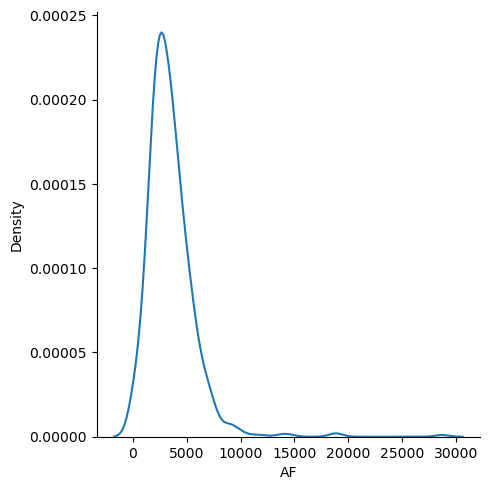

In [75]:
sns.displot(x.iloc[:,1],kind="kde")

In [112]:
for i in range(6):
    q1=df.iloc[:,i].quantile(0.25)
    q3=df.iloc[:,i].quantile(0.75)
    iqr = q3-q1
    df.iloc[:,i] = df.iloc[:,i].where((df.iloc[:,i]>=q1-1.5*iqr) & (df.iloc[:,i]<=q3+1.5*iqr))

In [113]:
df =  df.dropna()

In [114]:
df

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0.145282,4773.60488,85.200147,8.368094,8.138688,3.587895,0.025578,8.577022,6.718768,4535.36370,...,3.811895,0.49706,0.067730,14.669254,188.923924,7886.435724,29.485204,63.986216,0.231559,0
606,0.478576,3055.71222,85.200147,31.081492,8.138688,3.295548,0.025578,12.755248,1.229900,5801.45111,...,4.777589,1.31950,0.338650,27.989718,72.611063,19035.709240,21.637615,9.953640,0.263504,0
607,0.423027,1691.67680,85.200147,18.904088,8.138688,6.865725,0.025578,13.687944,3.823232,3895.94797,...,0.173229,0.49706,0.115141,19.794656,72.611063,143790.071200,24.566042,38.551708,21.978000,0
609,0.367478,4461.60154,85.200147,25.842917,8.138688,5.731773,0.032277,8.444680,5.882436,4668.19745,...,4.234008,0.49706,0.067730,25.217722,72.611063,7113.007548,25.831182,17.505032,0.208286,0


In [96]:
test_df=pd.read_csv(path + "test.csv")
temp = test_df["Id"]
test_df.drop("Id",axis=1,inplace=True)
test_df["EJ"]=test_df["EJ"].map({"A":1,"B":0})
z_scores = (test_df - test_df.mean()) / test_df.std()
threshold = 3
outliers = np.abs(z_scores) > 3
test_df[test_df.columns] = np.where(outliers, test_df.mean(), test_df)
test_df[test_df.columns] = imputer.transform(test_df)

In [97]:
y_pred = best_model.predict_proba(test_df)
res= pd.DataFrame()
res["Id"]=temp
res["class_0"] = [i[0] for i in y_pred]
res["class_1"] = [i[1] for i in y_pred]
res

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


,Id,class_0,class_1
0,00eed32682bb,0.87742,0.12258
1,010ebe33f668,0.87742,0.12258
2,02fa521e1838,0.87742,0.12258
3,040e15f562a2,0.87742,0.12258
4,046e85c7cc7f,0.87742,0.12258


In [98]:
res.to_csv('submission.csv',index=False)